<a href="https://colab.research.google.com/github/mabelc/EDA_medium/blob/main/eda_sensor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup & Load Data

In [ ]:
!wget https://github.com/mabelc/EDA_medium/blob/main/Datasets_Healthy_Older_People.zip?raw=true

In [ ]:
!unzip /content/Datasets_Healthy_Older_People.zip?raw=true

In [3]:
!rsync -a /content/Datasets_Healthy_Older_People/S1_Dataset/ /content/Datasets_Healthy_Older_People/S2_Dataset

In [4]:
!rm -rf /content/Datasets_Healthy_Older_People/S1_Dataset

In [ ]:
!pip install distfit

In [6]:
import os
import math
import collections
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import statsmodels.api as sm
import matplotlib.pyplot as plt

from typing import Dict
from typing import List
from distfit import distfit
from scipy.stats import zscore

DIR_DATASET = '/content/Datasets_Healthy_Older_People/S2_Dataset'

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [8]:
# filtering out the readme files
files_names = os.listdir(DIR_DATASET)
files_names = [f for f in files_names if f[0]=='d']

In [9]:
# Counting files by room
d1 = [f for f in files_names if f[1]=='1']
d2 = [f for f in files_names if f[1]=='2']
len(d1), len(d2)

(60, 27)

In [10]:
# create a dictionary from data
def load_data(dir_dataset: str):
    """
    Load data and creates a dictionary.

    Parameters:
    dir_dataset: directory of dataset files.

    Returns:
    Dictionary containing all files.

    """
    features = ["time",
                "frontal",
                "vertical",
                "lateral",
                "id_antenna",
                "rssi",
                "phase",
                "frequency",
                "label"]
    sensor_ds = {}

    for f in files_names:
      file_name = os.path.join(dir_dataset, f)
      df = pd.read_csv(file_name, names=features)
      df.set_index('time', inplace=True)
      base_name = os.path.basename(f)
      sensor_ds[base_name] = df
    return sensor_ds

sensor_ds = load_data(DIR_DATASET)

In [11]:
# showing some rows of file d2p01F
sensor_ds["d2p01F"].head()

,frontal,vertical,lateral,id_antenna,rssi,phase,frequency,label
time,,,,,,,,
0.00,-0.232160,0.215880,-1.18820,2,-48.5,2.74430,920.75,3
0.25,-0.056282,0.043636,-1.14260,2,-50.0,2.36540,921.75,3
0.50,0.143050,0.296270,-1.33640,3,-59.5,0.20709,922.25,3
0.75,0.318930,0.284780,-0.92593,2,-51.0,0.41571,923.25,3
1.05,0.412730,0.135500,-1.02860,2,-44.5,4.45470,920.25,3


# Preliminary plots

In [22]:
def plot_numb_observations(sensor_ds: Dict[str, pd.DataFrame]):
    """
    Plot the total number of observations per file.

    Parameters:
    sensor_ds: dataset.

    """
    observations = []
    for file_name, df in sensor_ds.items():
      observations.append(df.shape[0])

    fig, ax = plt.subplots(figsize=(15,6))
    plt.bar(sensor_ds.keys(), observations)
    plt.xticks(rotation=90)
    plt.title("Observations per file")
    plt.xlabel("Files")
    plt.ylabel("Number of observations")
    return fig, ax


def time_series_plot(sensor_ds:Dict[str, pd.DataFrame], 
                     file_name:str, features:List[str], 
                     title:str, xlabel:str, ylabel:str):
    """
    Plot selected features of a specific file.

    Parameters:
    sensor_ds: dataset.
    file_name: dictionary key
    features: list of features to plot
    title: title to show in the plot
    xlabel: label for x axis
    ylabel: label for y axis

    """
    fig = sensor_ds[file_name].loc[:,features].plot(figsize=(15,8))
    change_points = np.where(np.diff(sensor_ds[file_name].label) != 0)[0]
    min_value = np.min(sensor_ds[file_name].loc[:,features].values)
    max_value = np.max(sensor_ds[file_name].loc[:,features].values)
    for i in change_points:
      plt.vlines(sensor_ds[file_name].index[i], min_value, max_value, colors='grey', linestyles='--', linewidth=0.8)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    return fig


def activit_plot(sensor_ds:Dict[str, pd.DataFrame], file_name:str):
    """
    Create an activity plot to describe a file.

    Parameters:
    sensor_ds: dataset.
    file_name: dictionary key
    """
    labels = []
    for i in range(1,5):
      labels.append(np.where(sensor_ds[file_name].label==i)[0])
    labels = [sensor_ds[file_name].index[c] for c in labels]
    colors1 = ['C{}'.format(i) for i in range(len(labels))]
    # create a horizontal plot
    fig = plt.figure(figsize=(15,7))
    lineoffsets = [1,2,3,4]
    plt.eventplot(labels, colors=colors1, lineoffsets=lineoffsets)
    plt.yticks([1,2,3,4], ["sit on bed",  "sit on chair", "lying", "ambulating"])
    plt.title("Activities performed")
    return fig


def sampling_rate_boxplot(dataset:Dict[str, pd.DataFrame]):
    diff_list = []
    labels = []
    for file_name, df in dataset.items():
        diff = np.diff(df.index)
        diff_list.append(diff)
        labels.append(file_name)

    diff_array = np.array(diff_list, dtype=object)
    fig = plt.figure(figsize=(15,7))
    plt.boxplot(diff_array, labels=labels)
    plt.xticks(rotation=90)
    plt.title("Time differences between consecutive readings")
    plt.xlabel("Files")
    plt.ylabel("Time difference (seconds)")

    return fig

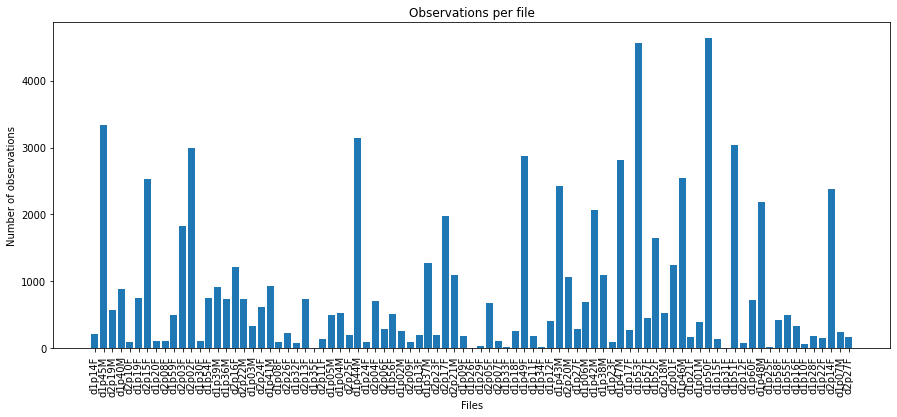

In [13]:
plot_numb_observations(sensor_ds);

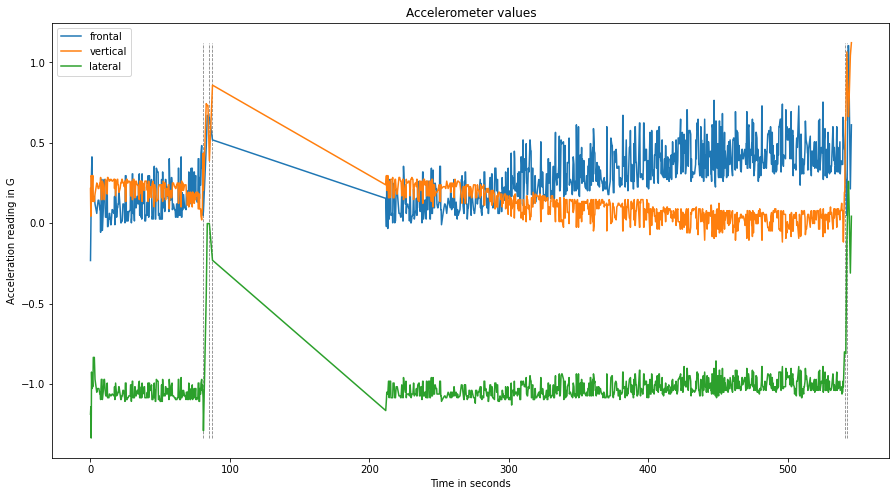

In [14]:
features = ["frontal","vertical","lateral"]
file_name = "d2p01F"
time_series_plot(sensor_ds, file_name, features, "Accelerometer values", "Time in seconds", "Acceleration reading in G");

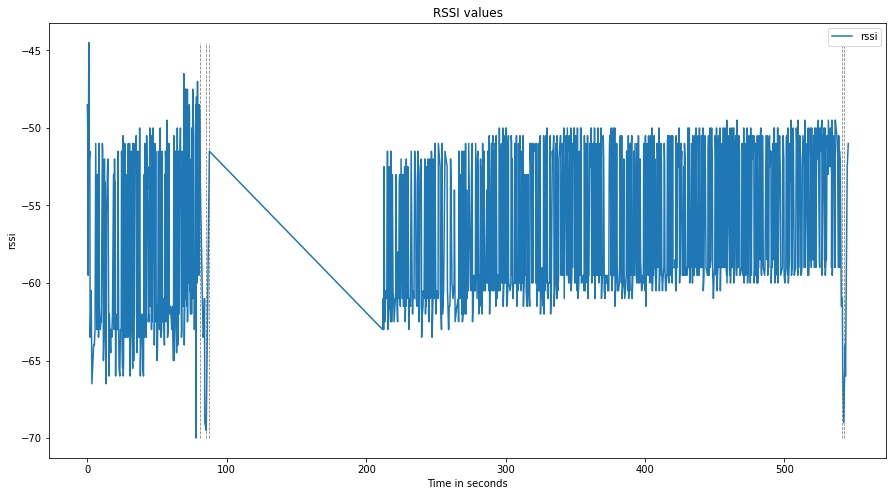

In [15]:
features = ["rssi"]
file_name = "d2p01F"
time_series_plot(sensor_ds, file_name, features, "RSSI values", "Time in seconds", "rssi");

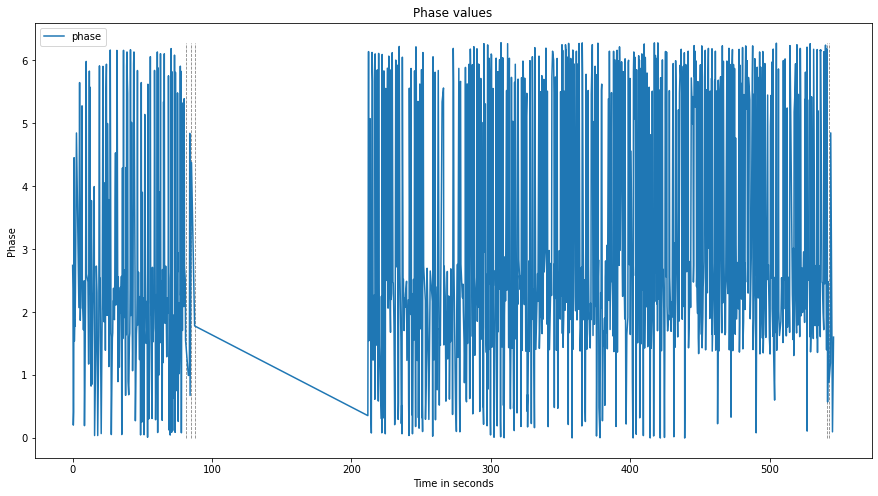

In [16]:
features = ["phase"]
file_name = "d2p01F"
time_series_plot(sensor_ds, file_name, features, "Phase values", "Time in seconds", "Phase");

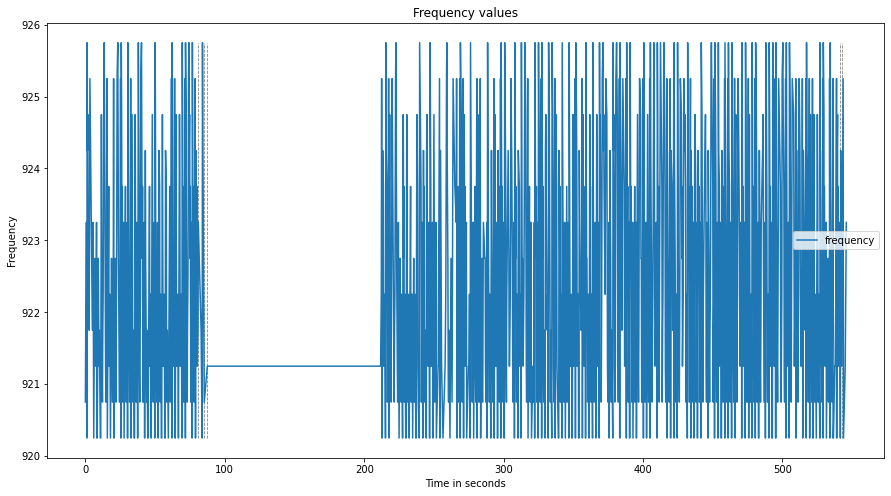

In [17]:
features = ["frequency"]
file_name = "d2p01F"
time_series_plot(sensor_ds, file_name, features, "Frequency values", "Time in seconds", "Frequency");

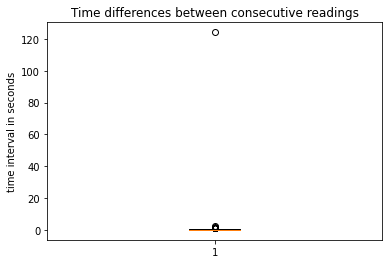

In [19]:
# creating a boxplot with time differences
plt.boxplot(np.diff(sensor_ds[file_name].index))
plt.ylabel("time interval in seconds")
plt.title("Time differences between consecutive readings")
plt.savefig("differences.png");

In [20]:
# expected difference
np.median(np.diff(sensor_ds[file_name].index))

0.25

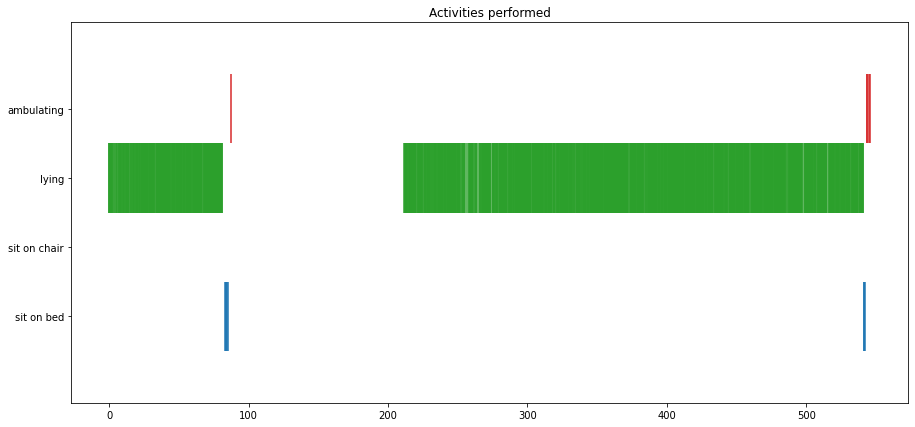

In [21]:
# activity plot
file_name = "d2p01F"
activit_plot(sensor_ds, file_name)
plt.savefig("activity_plot.png")

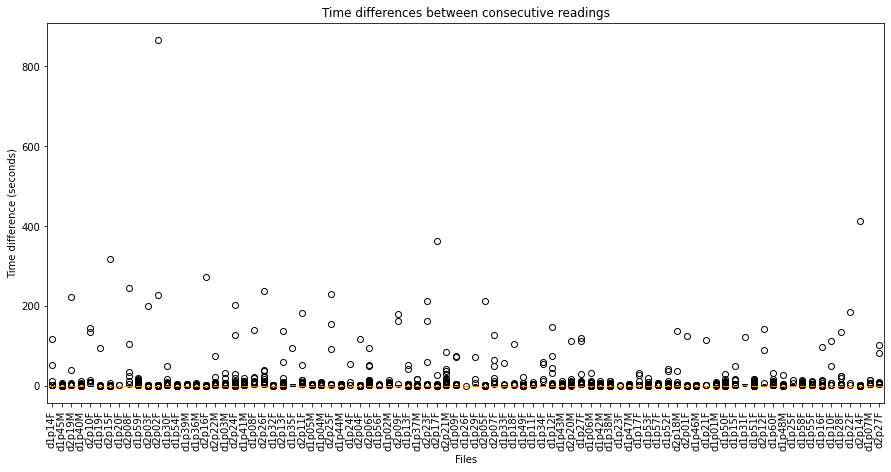

In [23]:
# time differences for all files
sampling_rate_boxplot(sensor_ds)
plt.savefig("differences_all_files.png");

# Correlation

In [24]:
def correlation_dataset(dataset:Dict[str, pd.DataFrame], ignore:List) -> Dict[str, np.ndarray]:
    """
    Compute correlations for every file in the dataset.

    Parameters:
    sensor_ds: dataset.
    ignore: features to exclude.

    Returns:
    Dictionary containing all correlation matrices.

    """
    sensor_corr = {}
    for file_name, df in dataset.items():
      df = df.drop(ignore, axis=1, inplace=False)
      sensor_corr[file_name] = df.corr()
    return sensor_corr


def plot_corr_file(df: pd.DataFrame, annot:bool, title:str, ax=None):
    """
    Plot a heatmat of correlations.

    Parameters:
    df: correlation dataframe.
    annot: including the numbers in the cells or not.
    ignore: features to exclude.
    title: title to show in the plot.
    ax: optional axes
    """
    axi = sns.heatmap(df,
                      cmap="YlGnBu",
                      vmax=1,
                      vmin=-1,
                      annot=annot,
                      ax=ax)
    axi.set_title(label=title)
    return axi


def plot_corr_dataset(sensor_corr: Dict[str, pd.DataFrame], figsize=(25,35)):
    """
    Plot correlation of every file in the dataset.

    Parameters:
    sensor_ds: dataset.
    figsize: the fig size.
    """
    ncols = 8
    nrows = math.ceil(len(sensor_corr)/ncols)
    fig, axs = plt.subplots(nrows=11, ncols=8, figsize=figsize)
    for i, file_name in enumerate(sensor_corr.keys()):
      plot_corr_file(sensor_corr[file_name], annot=False, title=file_name, ax=axs[i//ncols, i%ncols])
      if (i%ncols == 0) and (i//ncols != nrows-1):
        axs[i//ncols, i%ncols].set_xticks([])
      elif (i//ncols == nrows-1) and (i%ncols != 0):
        axs[i//ncols, i%ncols].set_yticks([])
      elif (i//ncols != nrows-1) and (i%ncols != 0):
        axs[i//ncols, i%ncols].set_xticks([])
        axs[i//ncols, i%ncols].set_yticks([])
    return


def plot_rolling_corr(corr_s: pd.Series, ax=None):
    """
    Plot a rolling correlation.

    Parameters:
    corr_s: the rolling correlation.
    ax: axes.
    """
    fig, ax = plt.subplots(figsize=(15,3))
    plot_corr_file(np.array(corr_s).reshape((1,len(corr_s))), annot=False, title="Rolling Correlation", ax=ax)
    ax.set_yticks([]);
    return fig, ax

In [25]:
# compute correlations for every file
sensor_corr = correlation_dataset(sensor_ds, ignore=['id_antenna', 'label'])

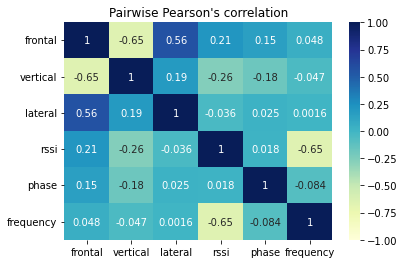

In [26]:
# plot annotated correlation for file
file_name = 'd2p01F'
plot_corr_file(sensor_corr[file_name], annot=True, title="Pairwise Pearson's correlation");

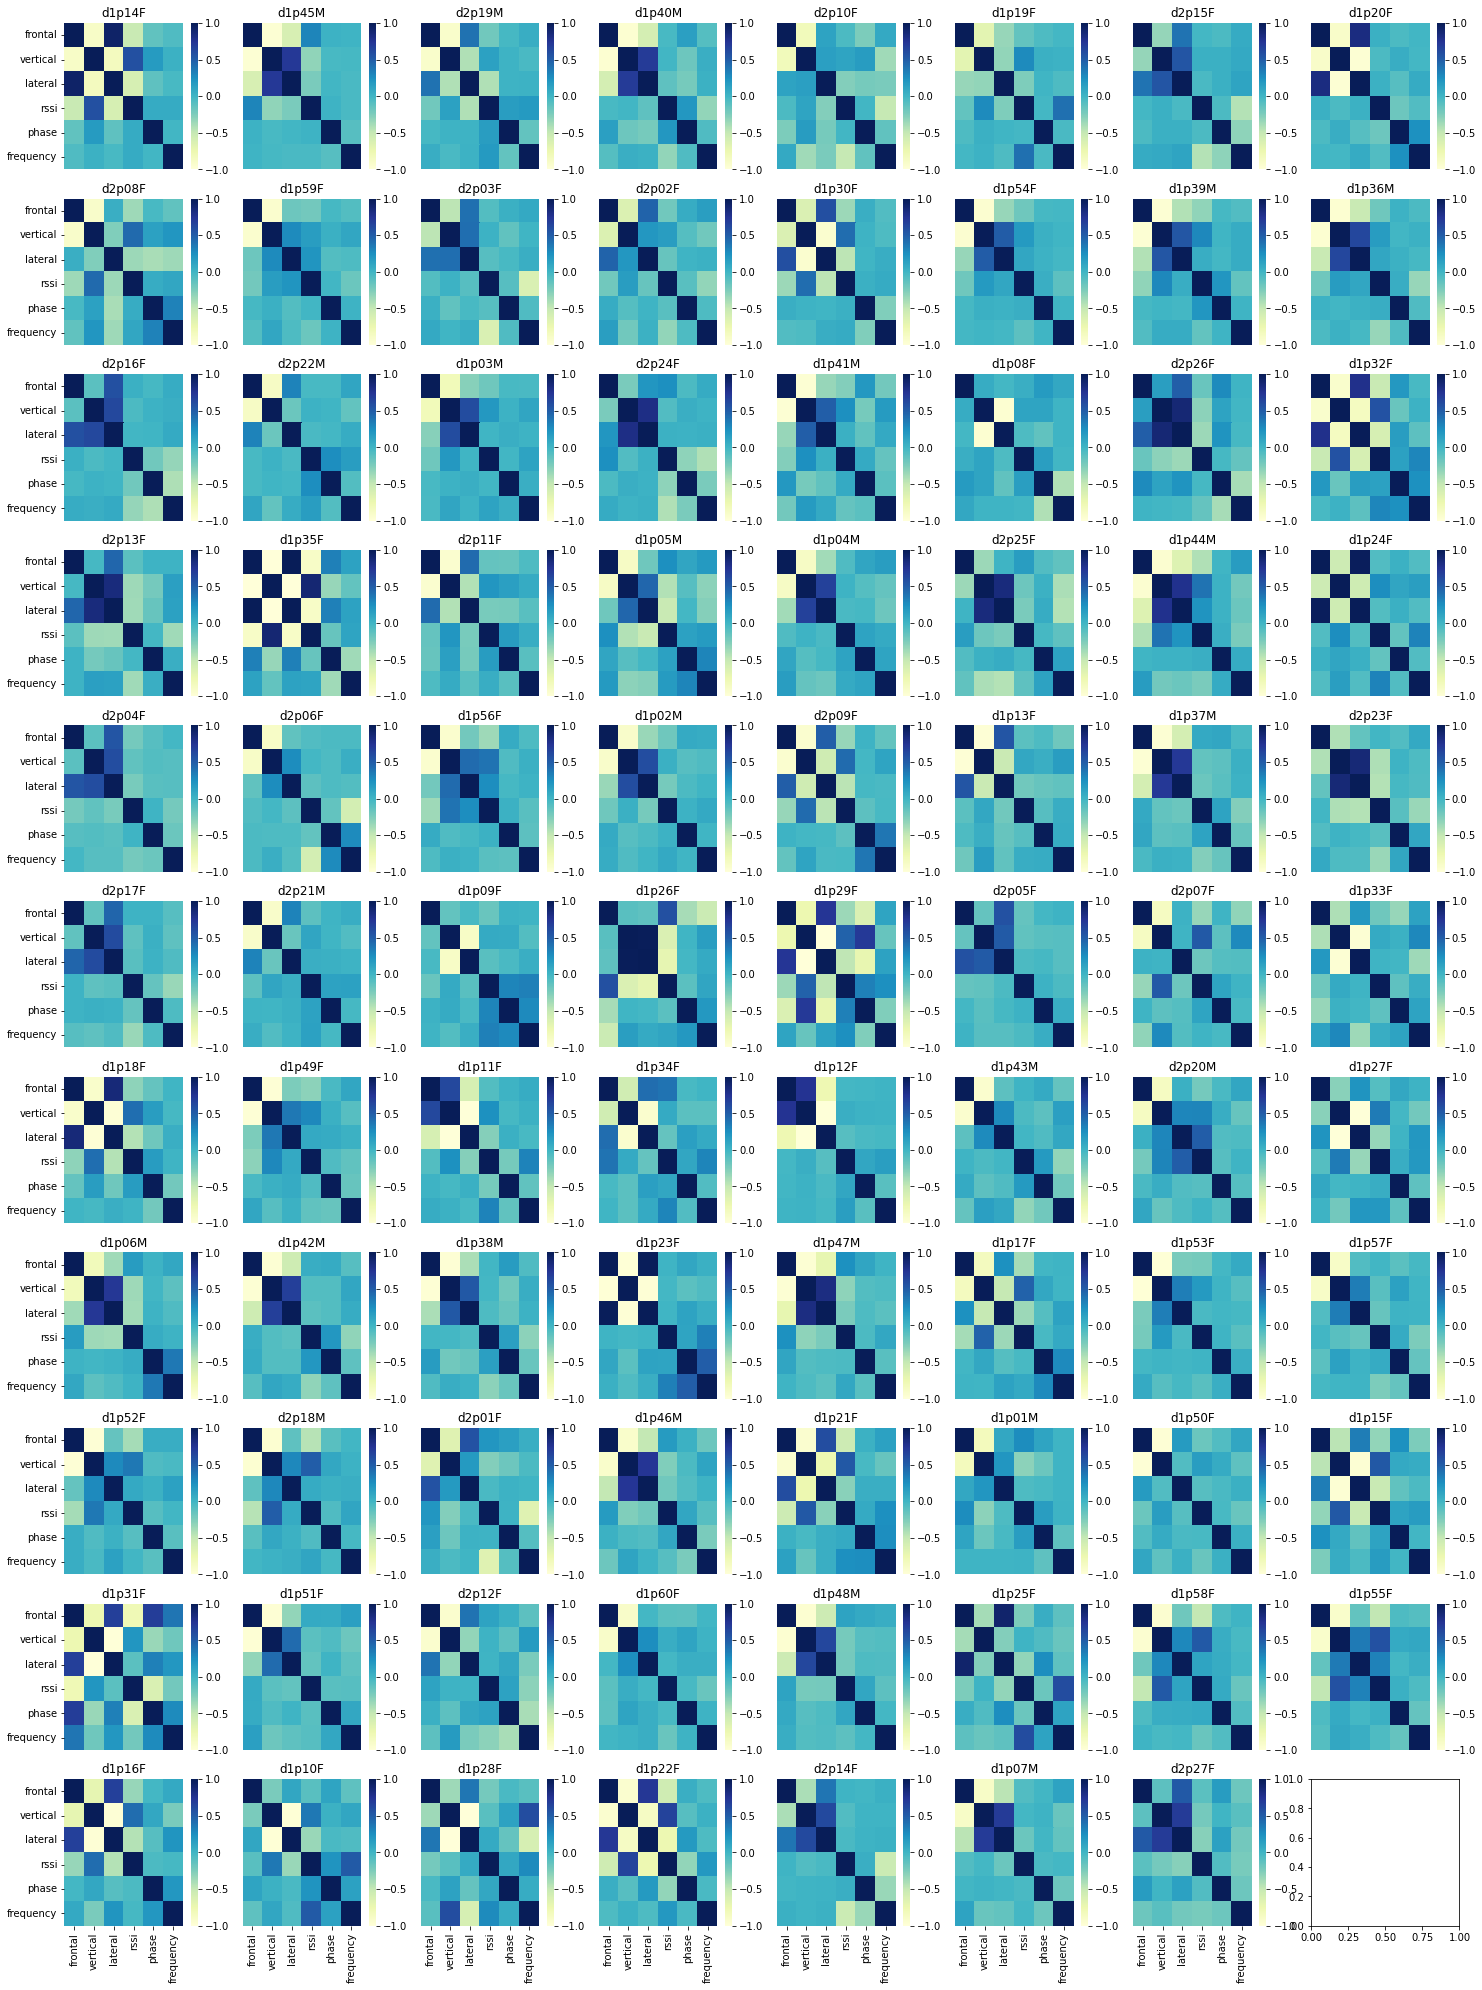

In [27]:
# plot correlation for all dataset
plot_corr_dataset(sensor_corr);

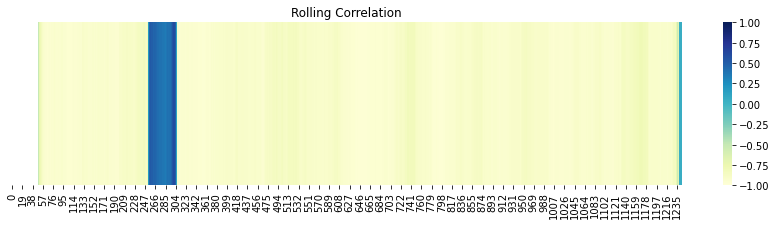

In [28]:
# compute and plot rolling correlation
file_name="d2p01F"
rolling_corr = sensor_ds[file_name].frontal.rolling(50).corr(sensor_ds[file_name].vertical)
plot_rolling_corr(rolling_corr)
plt.savefig("rolling_correlation_all.png");

# Distributions

In [29]:
def dist_counter(sensor_ds:Dict[str, pd.DataFrame], features:List[str]) -> Dict[str, Dict[str, int]]:
    """
    Computes and summarizes the matching distributions for all dataset.

    Parameters:
    sensor_ds: dataset.
    features: features to include in the analysis.

    Returns:
    A dictionary with the distributions counts per feature.
    """
    distributions_features = {}
    for f in features:
      dist_list = []
      for _, df in sensor_ds.items():
        dist = distfit()
        dist.fit_transform(df.loc[:, f].values, 0)
        dist_list.append(dist.model['name'])
      dist_dict = collections.Counter(dist_list)
      distributions_features[f] = dist_dict
    return distributions_features


def plot_dist_summary(dist_summary: Dict[str, Dict[str, int]]):
    """
    Plot a distribution summary.

    Parameters:
    dist_summary: distribution summary.
    """
    fig, axs = plt.subplots(nrows=1, ncols=len(dist_summary), figsize=(20, 2))
    for i, f in enumerate(dist_summary.keys()):
      dist = dist_summary[f]
      axs[i].bar(range(len(dist)), dist.values(), tick_label=list(dist.keys()))
      axs[i].tick_params(labelrotation=90)
      axs[i].set_title(f)

    return fig, axs


## original code: https://medium.com/r/?url=https%3A%2F%2Fgithub.com%2Frougier%2Fscientific-visualization-book%2Fblob%2Fmaster%2Fcode%2Fanatomy%2Fzorder-plots.py
## some modifications have been introduced in this implementation
def plot_comparative_distributions(
    sensor_ds: Dict[str, pd.DataFrame],
    normalize: bool = True,
    factor: int = 3,
):
    """
    zorder plot to describe the distribution per dimension.

    Parameters:
    sensor_ds: dictionary of elements to visualize
    of instances with shape Nxsubcs
    labels: list of labels to name the columns
    normalize: if zscore should be applied before the visualization
    factor: a number to multiply the probablility values to hightly the distribution shapes

    Returns:
    fig, axs
    """
    labels = list(sensor_ds.keys())
    subcs = sensor_ds[labels[0]].shape[1]
    feat_names = sensor_ds[labels[0]].columns
    xlim = (-3, 3) if normalize else (-100, 20)
    ncols = len(sensor_ds)
    nrows = 1
    cmap = mpl.cm.get_cmap("Spectral")
    fig = plt.figure(figsize=(10, 10))
    ax = None
    for n in range(ncols):

        ax = plt.subplot(nrows, ncols, n + 1, frameon=False, sharex=ax)
        for i in range(subcs):
            y = sensor_ds[labels[n]].values[:, i]
            if normalize:
                y = zscore(y)
            dens = sm.nonparametric.KDEUnivariate(y)
            dens.fit()
            X = np.linspace(xlim[0], xlim[1], len(y))
            Y = dens.evaluate(X)
            ax.plot(X, factor * Y + i, color="k", linewidth=0.75, zorder=100 - i)
            color = cmap(i / subcs)
            ax.fill_between(X, factor * Y + i, i, color=color, zorder=100 - i)
            # Value with highest prob
            text = np.round(X[np.argmax(Y)], 1)
            ax.text(
                xlim[1],
                i + 0.1,
                text,
                ha="right",
                va="baseline",
                size=8,
                transform=ax.transData,
                zorder=300,
            )
        ax.yaxis.set_tick_params(tick1On=False)
        ax.set_xlim(xlim[0], xlim[1])
        ax.set_ylim(0, subcs)
        if normalize:
            x = 0
        else:
            x = 30
        ax.axvline(x, ls="--", lw=0.75, color="black", zorder=250)
        ax.text(
            0.0,
            1.0,
            labels[n],
            ha="left",
            va="top",
            weight="bold",
            transform=ax.transAxes,
        )

        if n == 0:
            ax.yaxis.set_tick_params(labelleft=True)
            ax.set_yticks(np.arange(subcs))
            ax.set_yticklabels(feat_names)
            for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(10)
                tick.label.set_verticalalignment("bottom")
        else:
            ax.yaxis.set_tick_params(labelleft=False)

    plt.tight_layout()
    return fig, ax

[distfit] >plot..


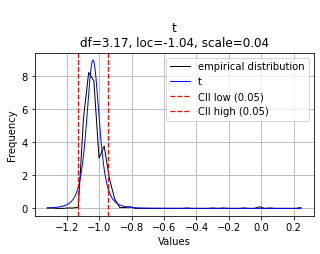

In [30]:
# find best distribution
file_name="d2p01F"
dist = distfit()
dist.fit_transform(sensor_ds[file_name].lateral, 0)
dist.plot(figsize=(5,3));

[distfit] >plot..


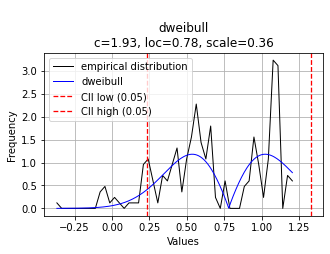

In [31]:
# find best distribution
file_name="d1p02M"
dist = distfit()
dist.fit_transform(sensor_ds[file_name].frontal, 0)
dist.plot(figsize=(5,3));

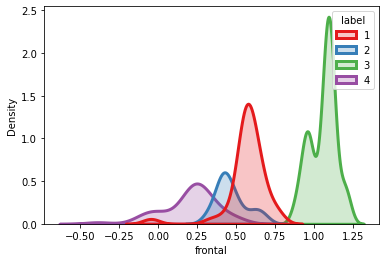

In [32]:
# plot kde separating by class, feature frontal
file_name = "d1p02M"
df = sensor_ds[file_name]
sns.kdeplot(df.frontal,
            shade=True,
            hue=df["label"],
            linewidth=3,
            palette=sns.color_palette("Set1", n_colors=len(df["label"].unique())),
            ax=None);


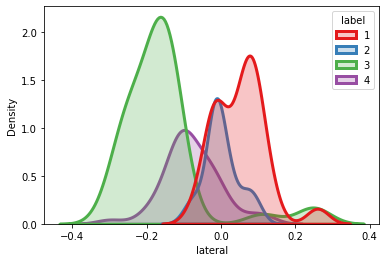

In [33]:
# plot kde separating by class, feature lateral
file_name = "d1p02M"
df = sensor_ds[file_name]
sns.kdeplot(df.lateral,
            shade=True,
            hue=df["label"],
            linewidth=3,
            palette=sns.color_palette("Set1", n_colors=len(df["label"].unique())),
            ax=None);

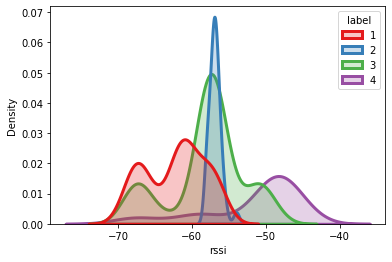

In [34]:
# plot kde separating by class, feature rssi
file_name = "d1p02M"
df = sensor_ds[file_name]
sns.kdeplot(df.rssi,
            shade=True,
            hue=df["label"],
            linewidth=3,
            palette=sns.color_palette("Set1", n_colors=len(df["label"].unique())),
            ax=None);

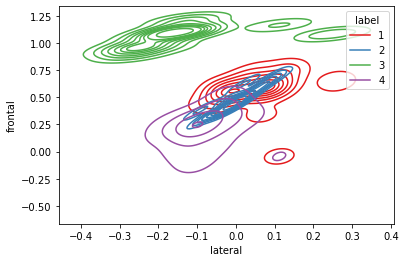

In [35]:
# plot kde separating by class, features lateral-frontal
sns.kdeplot(df['lateral'], 
            y=df['frontal'],
            hue=df["label"],
            palette=sns.color_palette("Set1", n_colors=len(df["label"].unique())));

In [37]:
# find distributions summary
dist_summary = dist_counter(sensor_ds, ["frontal", "vertical", "lateral", "rssi", "phase", "frequency"])

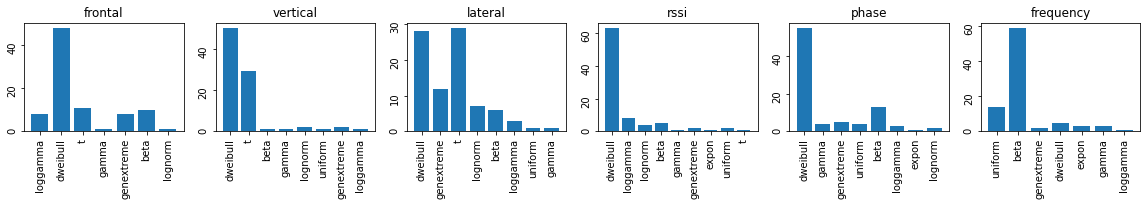

In [38]:
# plot distributions summary
plot_dist_summary(dist_summary);


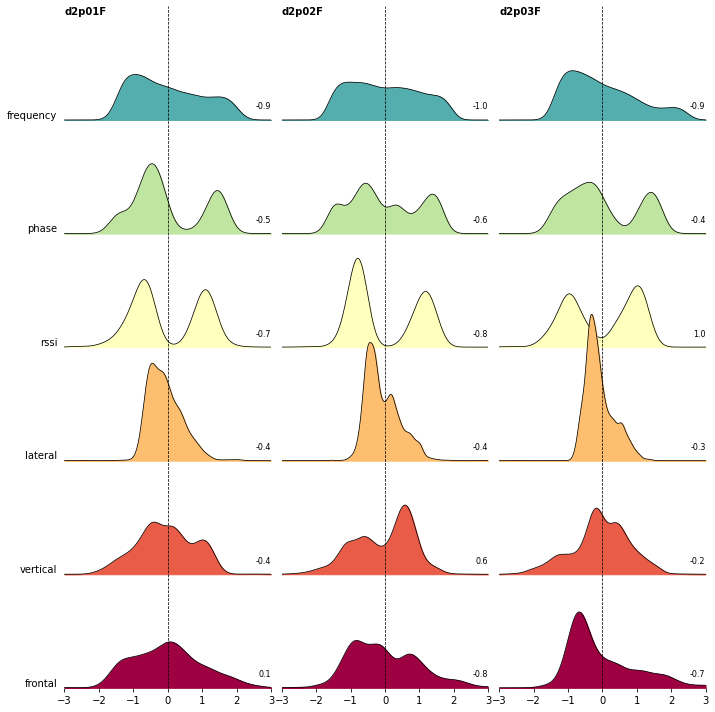

In [39]:
# visualize distributions of three files
ignore = ["id_antenna", "label"]
sensor_subset = {}
sensor_subset["d2p01F"] = sensor_ds["d2p01F"].drop(ignore, axis=1, inplace=False)
sensor_subset["d2p02F"] = sensor_ds["d2p02F"].drop(ignore, axis=1, inplace=False)
sensor_subset["d2p03F"] = sensor_ds["d2p03F"].drop(ignore, axis=1, inplace=False)
plot_comparative_distributions(sensor_subset, True, factor=1);